In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [40]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [41]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [42]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=10
latent_dimensions=16

num=4000
comps=2

beta=0.1

In [43]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp/ipykernel_584/834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [44]:
blends_max=np.amax(blended)
blends_min=np.amin(blended)
comp_max=np.amax(components)
comp_min=np.amin(components)

blended-=blends_min
blended/=blends_max
components-=comp_min
components/=comp_max

blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

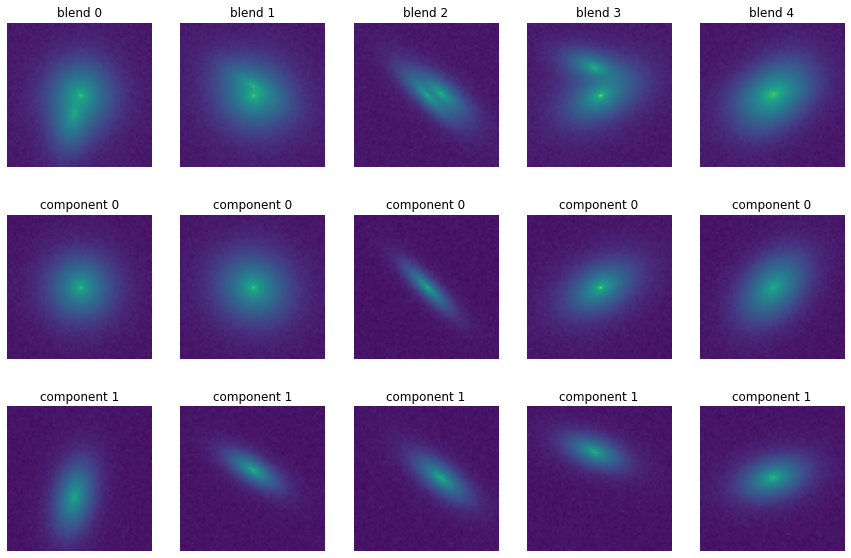

In [45]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [46]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [47]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [48]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [49]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [50]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 32, 32, 32)   320         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_9[0][0]                   
______________________________________________________________________________________

In [51]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_13 (Functional)   (None, 16)                73216     
_________________________________________________________________
functional_15 (Functional)   (None, 64, 64, 1)         106209    
Total params: 179,425
Trainable params: 179,425
Non-trainable params: 0
_________________________________________________________________


In [52]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [53]:
history=vae.fit(components[0],verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 11s 32ms/step - loss: 6.8893 - mse_loss: 6.6389 - kl_loss: 0.2504 - val_loss: 1.4573 - val_mse_loss: 1.1955 - val_kl_loss: 0.2619
Epoch 2/100
360/360 [==============================] - 11s 30ms/step - loss: 1.0886 - mse_loss: 0.8442 - kl_loss: 0.2444 - val_loss: 0.9640 - val_mse_loss: 0.7389 - val_kl_loss: 0.2252
Epoch 3/100
360/360 [==============================] - 12s 32ms/step - loss: 0.9209 - mse_loss: 0.7056 - kl_loss: 0.2153 - val_loss: 0.8043 - val_mse_loss: 0.5986 - val_kl_loss: 0.2057
Epoch 4/100
360/360 [==============================] - 11s 31ms/step - loss: 0.8191 - mse_loss: 0.6221 - kl_loss: 0.1970 - val_loss: 0.8019 - val_mse_loss: 0.6167 - val_kl_loss: 0.1852
Epoch 5/100
360/360 [==============================] - 10s 28ms/step - loss: 0.7520 - mse_loss: 0.5672 - kl_loss: 0.1848 - val_loss: 0.7176 - val_mse_loss: 0.5404 - val_kl_loss: 0.1772
Epoch 6/100
360/360 [==============================] - 10s 28ms/step - loss

360/360 [==============================] - 10s 28ms/step - loss: 0.5225 - mse_loss: 0.4463 - kl_loss: 0.0762 - val_loss: 0.5104 - val_mse_loss: 0.4339 - val_kl_loss: 0.0764
Epoch 46/100
360/360 [==============================] - 10s 28ms/step - loss: 0.5116 - mse_loss: 0.4355 - kl_loss: 0.0761 - val_loss: 0.5554 - val_mse_loss: 0.4783 - val_kl_loss: 0.0771
Epoch 47/100
360/360 [==============================] - 10s 29ms/step - loss: 0.5343 - mse_loss: 0.4578 - kl_loss: 0.0764 - val_loss: 0.6454 - val_mse_loss: 0.5658 - val_kl_loss: 0.0796
Epoch 48/100
360/360 [==============================] - 10s 29ms/step - loss: 0.5122 - mse_loss: 0.4362 - kl_loss: 0.0760 - val_loss: 0.5264 - val_mse_loss: 0.4497 - val_kl_loss: 0.0767
Epoch 49/100
360/360 [==============================] - 11s 30ms/step - loss: 0.5107 - mse_loss: 0.4353 - kl_loss: 0.0754 - val_loss: 0.5180 - val_mse_loss: 0.4402 - val_kl_loss: 0.0779
Epoch 50/100
360/360 [==============================] - 10s 29ms/step - loss: 0.517

360/360 [==============================] - 15s 41ms/step - loss: 0.4986 - mse_loss: 0.4263 - kl_loss: 0.0724 - val_loss: 0.4980 - val_mse_loss: 0.4255 - val_kl_loss: 0.0725loss: 0.4263 - kl_
Epoch 89/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4961 - mse_loss: 0.4243 - kl_loss: 0.0718 - val_loss: 0.5163 - val_mse_loss: 0.4455 - val_kl_loss: 0.0708
Epoch 90/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4996 - mse_loss: 0.4275 - kl_loss: 0.0721 - val_loss: 0.5130 - val_mse_loss: 0.4384 - val_kl_loss: 0.0746
Epoch 91/100
360/360 [==============================] - 14s 40ms/step - loss: 0.4965 - mse_loss: 0.4247 - kl_loss: 0.0717 - val_loss: 0.4969 - val_mse_loss: 0.4249 - val_kl_loss: 0.0719
Epoch 92/100
360/360 [==============================] - 15s 40ms/step - loss: 0.4951 - mse_loss: 0.4233 - kl_loss: 0.0718 - val_loss: 0.4988 - val_mse_loss: 0.4249 - val_kl_loss: 0.0739
Epoch 93/100
360/360 [==============================] - 14s 40ms/

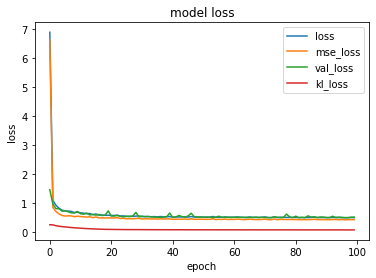

In [54]:
loss_plot(history)

In [55]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


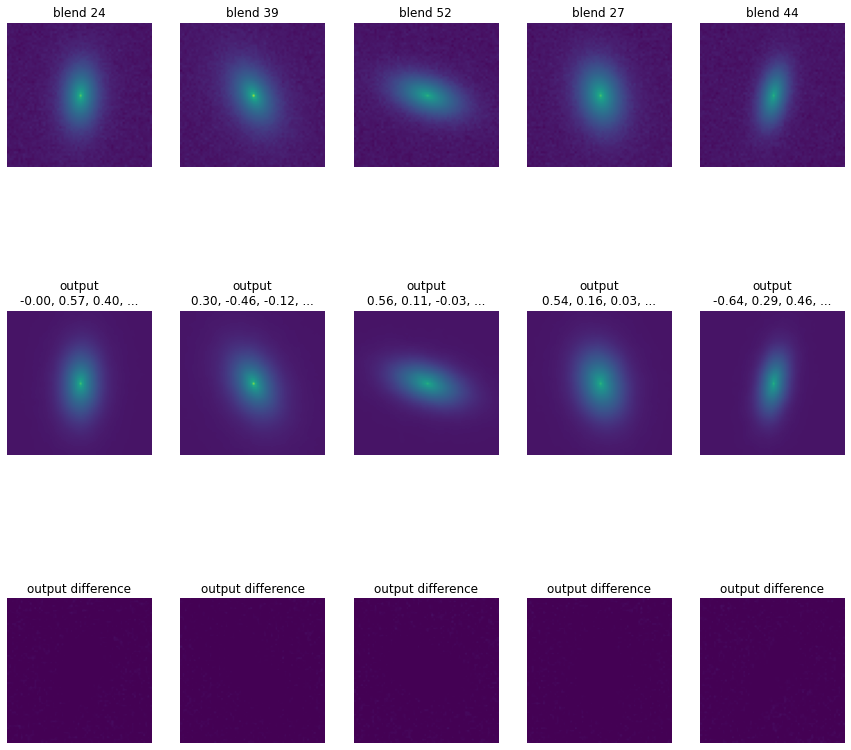

In [56]:
chosen=summary_plot(n,components[0],decode)

In [57]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [58]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 32, 32, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 16, 16, 32)   9248        conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 8, 8, 64)     18496       conv2d_13[0][0]                  
______________________________________________________________________________________

In [59]:
encoding2=encode2(inputs2,input_compc) #define the network
re2=decode([encoding2,input_compc])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_19 (Functional)      (None, 16)           73216       input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
functional_15 (Functional)      (None, 64, 64, 1)    106209      functional_19[0][0]  

In [60]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [61]:
history=vae.fit(together,verbose=1,epochs=100,batch_size=batch_size,validation_split=0.1)

Epoch 1/100
360/360 [==============================] - 13s 35ms/step - loss: 5.0253 - mse_loss: 4.9588 - kl_loss: 0.0666 - val_loss: 3.4375 - val_mse_loss: 3.3450 - val_kl_loss: 0.0926
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 2.9264 - mse_loss: 2.8425 - kl_loss: 0.0838 - val_loss: 3.0406 - val_mse_loss: 2.9725 - val_kl_loss: 0.0681
Epoch 3/100
360/360 [==============================] - 11s 32ms/step - loss: 2.4141 - mse_loss: 2.3334 - kl_loss: 0.0807 - val_loss: 2.2510 - val_mse_loss: 2.1739 - val_kl_loss: 0.0772
Epoch 4/100
360/360 [==============================] - 12s 33ms/step - loss: 2.1958 - mse_loss: 2.1189 - kl_loss: 0.0768 - val_loss: 2.2702 - val_mse_loss: 2.1905 - val_kl_loss: 0.0797
Epoch 5/100
360/360 [==============================] - 11s 32ms/step - loss: 1.9845 - mse_loss: 1.9084 - kl_loss: 0.0761 - val_loss: 1.9632 - val_mse_loss: 1.8806 - val_kl_loss: 0.0826
Epoch 6/100
360/360 [==============================] - 12s 32ms/step - loss

360/360 [==============================] - 11s 32ms/step - loss: 0.9051 - mse_loss: 0.8329 - kl_loss: 0.0722 - val_loss: 1.2308 - val_mse_loss: 1.1636 - val_kl_loss: 0.0671s: 0.8856 - ms - ETA: 3s - los
Epoch 38/100
360/360 [==============================] - 11s 32ms/step - loss: 0.8862 - mse_loss: 0.8137 - kl_loss: 0.0725 - val_loss: 1.1740 - val_mse_loss: 1.1061 - val_kl_loss: 0.06793s - l - E - ETA: 0s - loss: 0.8864 - mse_loss: 0.8139 - kl_loss: 0.07
Epoch 39/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8558 - mse_loss: 0.7837 - kl_loss: 0.0721 - val_loss: 1.1779 - val_mse_loss: 1.1105 - val_kl_loss: 0.0674
Epoch 40/100
360/360 [==============================] - 12s 35ms/step - loss: 0.8685 - mse_loss: 0.7952 - kl_loss: 0.0733 - val_loss: 1.2929 - val_mse_loss: 1.2188 - val_kl_loss: 0.0741 loss: 0
Epoch 41/100
360/360 [==============================] - 12s 33ms/step - loss: 0.8976 - mse_loss: 0.8258 - kl_loss: 0.0718 - val_loss: 1.1593 - val_mse_loss: 1.08

360/360 [==============================] - 12s 32ms/step - loss: 0.7072 - mse_loss: 0.6348 - kl_loss: 0.0723 - val_loss: 1.0978 - val_mse_loss: 1.0227 - val_kl_loss: 0.0751
Epoch 79/100
360/360 [==============================] - 11s 31ms/step - loss: 0.7052 - mse_loss: 0.6331 - kl_loss: 0.0721 - val_loss: 1.0892 - val_mse_loss: 1.0169 - val_kl_loss: 0.0723
Epoch 80/100
360/360 [==============================] - 12s 34ms/step - loss: 0.6958 - mse_loss: 0.6239 - kl_loss: 0.0719 - val_loss: 1.0990 - val_mse_loss: 1.0270 - val_kl_loss: 0.0721
Epoch 81/100
360/360 [==============================] - 13s 35ms/step - loss: 0.7153 - mse_loss: 0.6439 - kl_loss: 0.0714 - val_loss: 1.1114 - val_mse_loss: 1.0420 - val_kl_loss: 0.0694- mse_loss: 0.6460 - kl_lo - ETA: 1s - loss: 0.716
Epoch 82/100
360/360 [==============================] - 13s 35ms/step - loss: 0.6901 - mse_loss: 0.6179 - kl_loss: 0.0723 - val_loss: 1.1598 - val_mse_loss: 1.0887 - val_kl_loss: 0.0711
Epoch 83/100
360/360 [===========

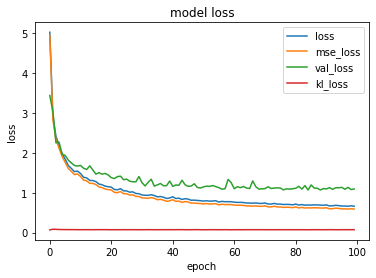

In [62]:
loss_plot(history)

In [63]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(5, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
        showimg(input_img[i]-output_img[i], ax[4, i], f'original difference')
    return idx

[ 200 1078  610 2159 1169]


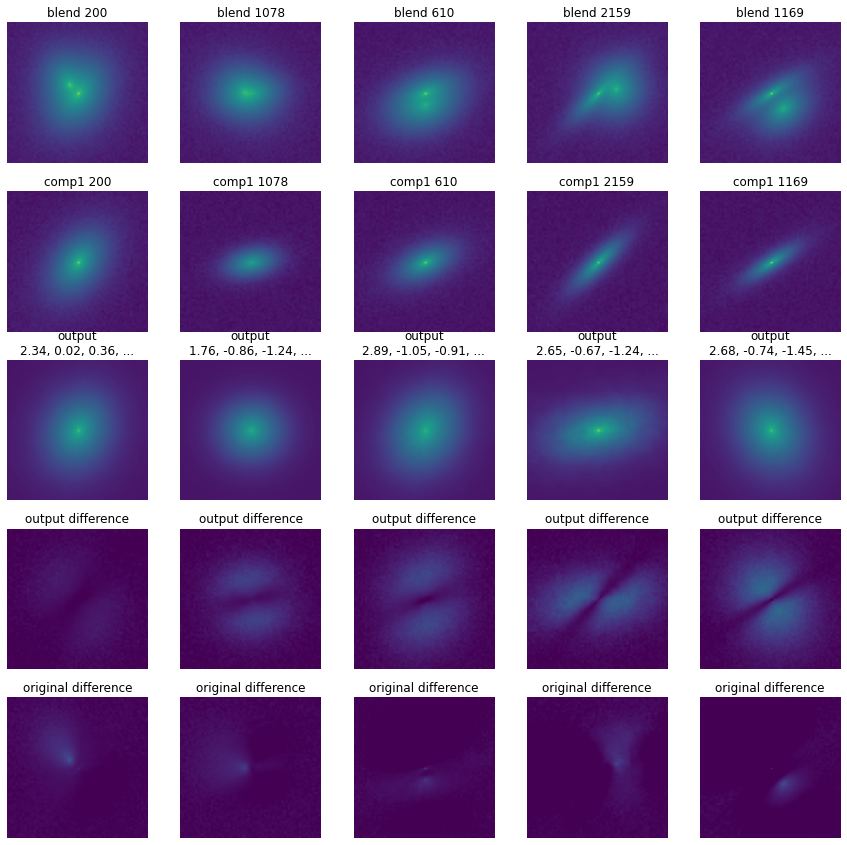

In [64]:
chosen=summary_plot(n,together,decode)

In [ ]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=0,batch_size=batch_size)
    losses[ite]=evals[0]
    #print(ite)
    
loss_max=np.amax(losses)
loss_min=np.amin(losses)
ax=plt.axes()
ax.hist(losses,bins=500)
ax.set_xlim(max(loss_min,0),min(loss_max,1)),ax.set_ylim(0)
ax.set_xlabel("Loss"),ax.set_ylabel("Frequency")

In [ ]:
vae.save_weights("model_1.h5")

In [ ]:
#vae=Model.load_weights("model_1.h5")
#vae.summary()